# Simulated Real-Time MLE Analysis
This will attempt to take a set of points, do Fourier analysis and identify significant frequencies, then do MLE on the data set to quantify the frequency behavior. I'm doing this to see the speed of this sort of computation, and to see if it could potentially be done in real time.

I want to try incrementally including more of the points into the analysis each time, so that errors which may not be visible in smaller batches become visible with larger samples of data.

In [4]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data
from helpers import *
from drift_file_io import drift_input, calculate_average_timestep, merge_lines, experiment_per_line
#################################################################################################################
#For reading in experimental data: enter here
base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/"
name = '2018_08_27 Gi Data/2018_08_27_1354_31_DRIFT'
file_loc = base + name + ".txt"
time_per_sample = 1/60 #seconds, only necessary if you're doing the manual entry
   
time_per_sample = 1/60 #seconds

ones_count_array, zeros_count_array, timestamp_array = merge_lines(file_loc, time_per_sample)###Currently reading each line as an experiment
top_freqs = []
top_freqs_occurence = []

In [11]:
nSample_list = [2000, 8000, 12000, 16000, 20000]

for nSamples in nSample_list:
    print("*********Currently testing with first {} samples, spanning {:.3f} seconds".format(nSamples, timestamp_array[nSamples]))
    nCounts = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
    nSamples = len(ones_count_array)
    drifted = drift.do_basic_drift_characterization(ones_count_array, counts=nCounts, timestep=time_per_sample,timestamps=timestamp_array, verbosity=0)
    #drifted.plot_power_spectrum(sequence=0, entity=0, outcome=1)
    #analyze the frequency-power spectrum
    frequencies = list(drifted.frequencies)
    power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
    sorted_groups = create_sorted_tuples(frequencies, power_spectrum)
    num_points = 10
    significant_frequency_threshold = 0.01
    top_significant_frequency = 0
    for i in range(num_points):
        f = sorted_groups[i][0]
        if f > significant_frequency_threshold:
            top_significant_frequency = f
            break
    top_freqs.append(f)
    print("From Fourier Transform: Top Frequency above {:.4} Hz: {:.4f} Hz".format(significant_frequency_threshold, f))
    


*********Currently testing with first 2000 samples, spanning 33.350 seconds
From Fourier Transform: Top Frequency above 0.01 Hz: 1.2076 Hz
*********Currently testing with first 8000 samples, spanning 133.350 seconds
From Fourier Transform: Top Frequency above 0.01 Hz: 1.2076 Hz
*********Currently testing with first 12000 samples, spanning 200.017 seconds
From Fourier Transform: Top Frequency above 0.01 Hz: 1.2076 Hz
*********Currently testing with first 16000 samples, spanning 266.683 seconds
From Fourier Transform: Top Frequency above 0.01 Hz: 1.2076 Hz
*********Currently testing with first 20000 samples, spanning 333.350 seconds
From Fourier Transform: Top Frequency above 0.01 Hz: 1.2076 Hz


In [6]:
##### Do 3D optimization here across the number of experiments

#specify indices of lines you want to test
experiment_indices = np.arange(0, 6)
form='sine'
f_range=np.linspace(1.19, 1.255, 40)
a_range=np.linspace(0.02, 0.045, 15)
p_range=np.linspace(0, 2*np.pi, 14)

if True:
    from max_likelihood import three_dimensional_optimization, p1_sine, p0_sine
    threeD_opt_params_list = []
    for exp_index in experiment_indices:
        print("On experiment {} out of {}".format(exp_index + 1, len(experiment_indices)))
        ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
        losses, opt_prob, opt_params = three_dimensional_optimization(timestamp_array, ones_count_array,
                                                                      f_range, a_range, p_range, form=form, verbose=False)
        threeD_opt_params_list.append(opt_params)
        #print(opt_params)
        
    threeD_f_list = [threeD_opt_params_list[i][0] for i in range(len(threeD_opt_params_list))]
    threeD_a_list = [threeD_opt_params_list[i][1] for i in range(len(threeD_opt_params_list))]
    threeD_p_list = [threeD_opt_params_list[i][2] for i in range(len(threeD_opt_params_list))]

    mean_threeD_f = np.mean(np.asarray(threeD_f_list))
    sigma_threeD_f = np.std(np.asarray(threeD_f_list))
    mean_threeD_a = np.mean(np.asarray(threeD_a_list))
    sigma_threeD_a = np.std(np.asarray(threeD_a_list))
    print("Using {} experiments:".format(len(experiment_indices)))
    print("Frequency mean: {:.3f} +- {:.3f} Hz".format(mean_threeD_f, sigma_threeD_f))
    print("Amplitude mean: {:.3f} +- {:.3f}".format(mean_threeD_a, sigma_threeD_a))


C:\Users\GA28573\AppData\Local\Continuum\anaconda32\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



On experiment 1 out of 6
On experiment 2 out of 6
On experiment 3 out of 6
On experiment 4 out of 6
On experiment 5 out of 6
On experiment 6 out of 6
Using 6 experiments:
Frequency mean: 1.218 +- 0.022 Hz
Amplitude mean: 0.028 +- 0.009


In [8]:
########### Use the scipy optimization here. To work, it requires a good guess in guess_params

#specify the indices of the lines you want to test
experiment_indices = np.arange(0, num_experiments)
form = 'sine'
guess_params = (1.2, 0.03, 0)

if True:
    from max_likelihood import three_dimensional_optimization, p1_sine, p0_sine
    scipy_opt_params_list = []
    for exp_index in experiment_indices:
        ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
        from max_likelihood import scipy_optimization
        opt_params = scipy_optimization(timestamp_array, ones_count_array, guess_params, form, plot=False, actual_params=None)
        scipy_opt_params_list.append(opt_params)
        #print(opt_params)
        
    scipy_f_list = [scipy_opt_params_list[i][0] for i in range(len(scipy_opt_params_list))]
    scipy_a_list = [scipy_opt_params_list[i][1] for i in range(len(scipy_opt_params_list))]
    scipy_p_list = [scipy_opt_params_list[i][2] for i in range(len(scipy_opt_params_list))]

    mean_scipy_f = np.mean(np.asarray(scipy_f_list))
    sigma_scipy_f = np.std(np.asarray(scipy_f_list))
    mean_scipy_a = np.mean(np.asarray(scipy_a_list))
    sigma_scipy_a = np.std(np.asarray(scipy_a_list))
    print("Using {} experiments:".format(len(experiment_indices)))
    print("Frequency mean: {:.3f} +- {:.3f} Hz".format(mean_scipy_f, sigma_scipy_f))
    print("Amplitude mean: {:.3f} +- {:.3f}".format(mean_scipy_a, sigma_scipy_a))

Using 157 experiments:
Frequency mean: 1.224 +- 0.069 Hz
Amplitude mean: 0.026 +- 0.011


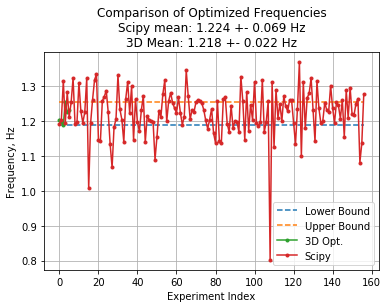

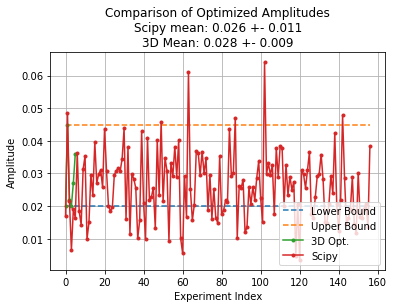

In [9]:
####### Compare the two optimization methods here
plt.plot([f_range[0]]*len(scipy_f_list), ls='dashed', label='Lower Bound')
plt.plot([f_range[-1]]*len(scipy_f_list), ls='dashed', label='Upper Bound')
plt.plot(threeD_f_list, label="3D Opt.", marker='.')
plt.plot(scipy_f_list, label="Scipy", marker='.')
plt.xlabel("Experiment Index")
plt.ylabel("Frequency, Hz")
plt.title("Comparison of Optimized Frequencies\nScipy mean: {:.3f} +- {:.3f} Hz\n3D Mean: {:.3f} +- {:.3f} Hz".format(
    mean_scipy_f, sigma_scipy_f, mean_threeD_f, sigma_threeD_f))
plt.grid()
plt.legend(loc='lower right')
plt.show()


plt.plot([a_range[0]]*len(scipy_a_list), ls='dashed', label='Lower Bound')
plt.plot([a_range[-1]]*len(scipy_a_list), ls='dashed', label='Upper Bound')
plt.plot(threeD_a_list, label="3D Opt.", marker='.')
plt.plot(scipy_a_list, label="Scipy", marker='.')
plt.xlabel("Experiment Index")
plt.ylabel("Amplitude")
plt.title("Comparison of Optimized Amplitudes\nScipy mean: {:.3f} +- {:.3f}\n3D Mean: {:.3f} +- {:.3f}".format(
    mean_scipy_a, sigma_scipy_a, mean_threeD_a, sigma_threeD_a))
plt.grid()
plt.legend(loc='lower right')
plt.show()